In [1]:
import numpy as np
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from IPython import display

from scipy.spatial.transform import Rotation as R

import math
from copy import copy
import glob

import random
from scipy.stats import kendalltau

# First, we'll load some data

In [2]:
flist = sorted(glob.glob('../../demos/perms/order*'))
random.shuffle(flist)

In [3]:
# Load 300 examples
obj_list = []
im_list = []
for i,f in enumerate(flist[0:300]):
    run = int(f.split('_')[1][:-4])

    im = np.load('../../demos/perms/ims_%04d.npy'%run)
    obj_ids = np.load('../../demos/perms/order_%04d.npy'%run)
    
    obj_list.append(obj_ids)
    im_list.append(im)

In [4]:
# Force into masked tensor structure
obj_idxs = np.ones((len(obj_list),6))*0
seq_len = []
for j,obj_idx in enumerate(obj_list):
    seq_len.append(obj_idx.shape[0]-1)
    obj_idxs[j,0:obj_idx.shape[0]] = obj_idx

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda:1")

# Next, we'll define a dataloader and Sinkhorn network

In [6]:
# Set up pytorch dataloader
class Sampler(Dataset):
    
    def __init__(self, ims, actions, seq_lens, K=6):
        
        self.ims = torch.FloatTensor(ims.astype('float')).to(device)
        self.actions = torch.FloatTensor(actions.astype('float')).to(device)
        self.K = K
        
        
    def __len__(self):
        
        return self.ims.shape[0]
    
    def __getitem__(self, index):
        
        im = self.ims[index,:,:,:]
        actions = self.actions[index,:]
        return im, actions, torch.FloatTensor(np.arange(self.K).astype('float')).to(device)


In [7]:
dataset = Sampler(np.swapaxes(np.stack(im_list),1,3),obj_idxs,6)

train_dataset,test_dataset = torch.utils.data.random_split(dataset, [200,len(im_list)-200])

In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class SinkhornNet(nn.Module):

    def __init__(self, latent_dim=16, image_channels=3, K=6, n_samples=5, noise_factor=1.0, temp=1.0, n_iters=20):
        super(SinkhornNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            Flatten(),
            nn.Linear(4096, latent_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        
        # Sinkhorn params
        self.latent_dim = latent_dim
        self.K = K
        self.n_samples = n_samples
        self.noise_factor = noise_factor
        self.temp = temp
        self.n_iters = n_iters
        
        self.criterion = nn.MSELoss()
        
        self.sinknet = nn.Sequential(nn.Linear(self.latent_dim, self.latent_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.latent_dim, K*K))
        
    def permute(self,seq,P):
        
        return torch.matmul(P,seq)
    
    def predict_P(self,im):
        
        latent = self.encoder(im)
        log_alpha = self.sinknet(latent)
        log_alpha = log_alpha.reshape(-1, self.K, self.K)
         
        soft_perms_inf, log_alpha_w_noise = self.gumbel_sinkhorn(log_alpha)
        
        P = self.inv_soft_pers_flattened(soft_perms_inf,self.K)
        return P
    
    def forward(self, seq, im):
        
        latent = self.encoder(im)
        log_alpha = self.sinknet(latent)
        log_alpha = log_alpha.reshape(-1, self.K, self.K)
         
        soft_perms_inf, log_alpha_w_noise = self.gumbel_sinkhorn(log_alpha)
        
        P = self.inv_soft_pers_flattened(soft_perms_inf,self.K)
        
        seq_tiled = seq.repeat(self.n_samples, 1)
        ordered  = self.permute(torch.unsqueeze(seq_tiled,dim=-1),P)
        
        return ordered
    
    def loss(self, seq, im, seq_gt):
        
        seq_pred = self.forward(seq_gt,im)
        seq_pred = torch.squeeze(seq_pred)

        recon_loss = self.criterion(seq_pred,seq.repeat(self.n_samples, 1))
         
        return recon_loss, seq_pred
    
    def inv_soft_pers_flattened(self,soft_perms_inf,n_numbers):
        inv_soft_perms = torch.transpose(soft_perms_inf, 2, 3)
        inv_soft_perms = torch.transpose(inv_soft_perms, 0, 1)

        inv_soft_perms_flat = inv_soft_perms.view(-1, n_numbers, n_numbers)
        return inv_soft_perms_flat
    
    def sample_gumbel(self, shape, eps=1e-20):
        U = torch.rand(shape).float().to(device)
        return -torch.log(eps - torch.log(U + eps))
    
    def gumbel_sinkhorn(self,log_alpha):
        
        n = log_alpha.size()[1]
        log_alpha = log_alpha.view(-1, n, n)
        batch_size = log_alpha.size()[0]

        log_alpha_w_noise = log_alpha.repeat(self.n_samples, 1, 1)

        if self.noise_factor == 0:
            noise = 0.0
        else:
            noise = self.sample_gumbel([self.n_samples*batch_size, n, n])*self.noise_factor

        log_alpha_w_noise = log_alpha_w_noise + noise
        log_alpha_w_noise = log_alpha_w_noise / self.temp

        my_log_alpha_w_noise = log_alpha_w_noise.clone()

        sink = self.sinkhorn(my_log_alpha_w_noise)

        sink = sink.view(self.n_samples, batch_size, n, n)
        sink = torch.transpose(sink, 1, 0)
        log_alpha_w_noise = log_alpha_w_noise.view(self.n_samples, batch_size, n, n)
        log_alpha_w_noise = torch.transpose(log_alpha_w_noise, 1, 0)

        return sink, log_alpha_w_noise
    
    def sinkhorn(self,log_alpha, n_iters = 20):
   
        n = log_alpha.size()[1]
        log_alpha = log_alpha.view(-1, n, n)

        for i in range(n_iters):
            log_alpha = log_alpha - (torch.logsumexp(log_alpha, dim=2, keepdim=True)).view(-1, n, 1)
            log_alpha = log_alpha - (torch.logsumexp(log_alpha, dim=1, keepdim=True)).view(-1, 1, n)
        return torch.exp(log_alpha)


# Now, let's train the network

In [10]:
sn = SinkhornNet(latent_dim=128, image_channels=3, K=6)
sn.to(device)
optimizer = torch.optim.Adam(sn.parameters(), lr=3e-4)
n_epochs = 5000
losses = []

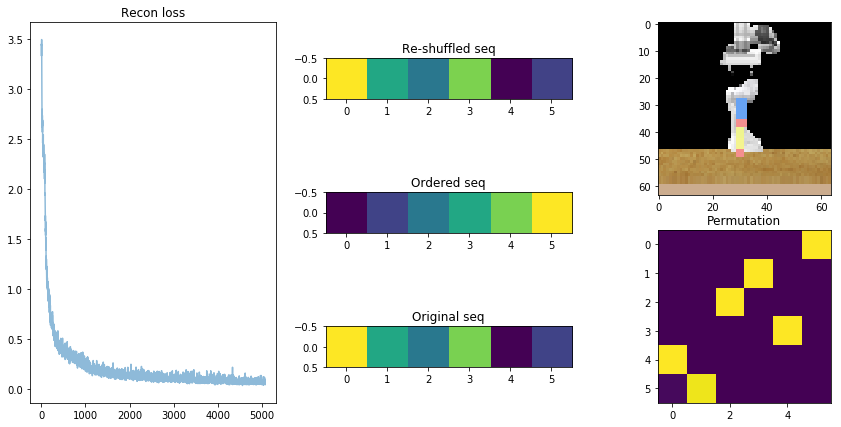

KeyboardInterrupt: 

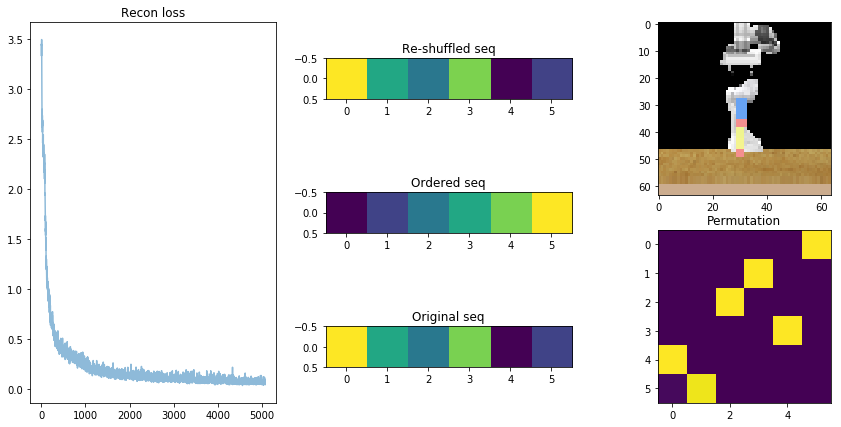

In [11]:
plt.figure(figsize=(15,7))

for j in range(n_epochs):
    
    batch_losses = []
    for im, seq, seq_order in train_loader:
    
        loss, seq_pred = sn.loss(seq, im, seq_order)
        
        batch_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    losses.append(np.mean(batch_losses))
    
    plt.clf()
    plt.cla()
    plt.subplot(1,3,1)
    plt.plot(losses,alpha=0.5)
    plt.title('Recon loss')

    plt.subplot(2,3,6)
    P = sn.predict_P(im)
    plt.imshow(P[0,:,:].cpu().detach().numpy())
    plt.title('Permutation')
    
    plt.subplot(3,3,2)
    plt.imshow(seq_pred[0,:].cpu().detach().numpy().reshape(1,-1))
    plt.title('Re-shuffled seq')
    
    plt.subplot(3,3,5)
    plt.imshow(seq_order[0,:].cpu().detach().numpy().reshape(1,-1))
    plt.title('Ordered seq')
    
    plt.subplot(3,3,8)
    plt.imshow(seq[0,:].cpu().detach().numpy().reshape(1,-1))
    plt.title('Original seq')
    
    plt.subplot(2,3,3)
    plt.imshow(np.swapaxes(im[0,:,:,:].cpu().detach().numpy(),0,2))
    
        
    display.clear_output(wait=True)
    display.display(plt.gcf())
    

# Now evaluate on test set

In [12]:
sn.eval()
sn.noise_factor = 0.0
sn.n_samples = 1
sn.n_iters = 100

In [13]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

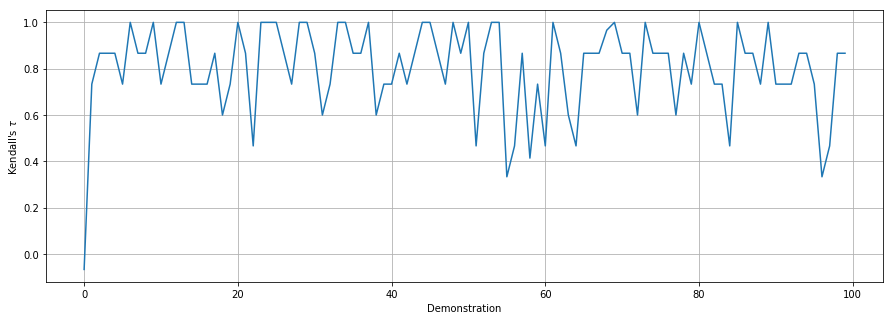

In [18]:
tau_list = []
for im,seq,seq_ordered in test_loader:
    P = sn.predict_P(im)
    obj_ids = np.argmax(P[0,:,:].cpu().detach().numpy(),1)
    tau, _ = kendalltau(obj_ids, seq.cpu().numpy())
    tau_list.append(tau)

plt.figure(figsize=(15,5))
plt.plot(tau_list)
plt.ylabel('Kendall\'s $\\tau$')
plt.xlabel('Demonstration')
plt.grid()
plt.show()

# Demonstrate in CoppeliaSim

In [ ]:
from pyrep import PyRep
from pyrep.robots.arms.panda import Panda
from pyrep.robots.end_effectors.panda_gripper import PandaGripper
import numpy as np
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from IPython import display

from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape

from scipy.spatial.transform import Rotation as R

import math
from copy import copy

In [ ]:
pr = PyRep()
pr.launch('../../assets/scene_panda.ttt', headless=False)

In [ ]:
agent = Panda()
gripper = PandaGripper()

In [ ]:
home_pos = agent.get_tip().get_position()
home_orient = agent.get_tip().get_orientation()

In [ ]:
def grasp(grip=False):
    if grip:
        pos = 0.1
    else:
        pos = 0.9
    actuated = False
    ims = []
    states = []
    while not actuated:
        actuated = gripper.actuate(pos,0.1)
        im0,im1 = get_image()
        ims.append((im0,im1))
        states.append(agent.get_tip().get_pose())
    return ims,states

In [ ]:
def move_above_object(object_name='',offset=0.05):
    pos = agent.get_object(object_name).get_position()
    pos[2] = pos[2] + offset
    orient = [-np.pi,0,np.pi/2]

    path = agent.get_path(position=pos,euler=orient)

    done = False
    ims = []
    states = []
    while not done:
        done = path.step()
        im0,im1 = get_image()
        ims.append((im0,im1))
        states.append(agent.get_tip().get_pose())
    return ims,states

In [ ]:
def get_image():
    cam = agent.get_object('Vision_sensor_front')
    im0 = cam.capture_rgb()
    cam1 = agent.get_object('Vision_sensor')
    im1 = cam1.capture_rgb()
    pr.step()
    return im0, im1

In [ ]:
# Set up a dataloader for testing
tl = iter(train_loader)

In [ ]:
# Run this repeatedly to see how the action sequencing works for different images
im,seq,seq_ordered,seq_len = next(tl)
P = sn.predict_P(im)
_,stop_logit = sn(seq_ordered,im)

stop_bin = np.argmax(stop_logit.detach().numpy(),-1)

obj_ids = np.argmax(P[0,:,:].detach().numpy(),1)[0:(stop_bin[0]+1)]

pr.start()

grasp(grip=False)
gripper.release()
ims = []
states = []
for j in range(1,len(obj_ids)):
    object_name = 'Cuboid%d'%obj_ids[j]
    i,s = move_above_object(object_name,offset=0.08)
    ims = ims + i
    states = states + s
    i,s = move_above_object(object_name,offset=0)
    ims = ims + i
    states = states + s
    i,s = grasp(grip=True)
    ims = ims + i
    states = states + s
    gripper.grasp(agent.get_object(object_name))
    i,s = move_above_object(object_name,offset=0.08)
    ims = ims + i
    states = states + s
    object_name = 'Cuboid%d'%obj_ids[j-1]
    i,s = move_above_object(object_name,offset=0.15)
    ims = ims + i
    states = states + s
    i,s = move_above_object(object_name,offset=0.05)
    ims = ims + i
    states = states + s
    i,s = grasp(grip=False)
    ims = ims + i
    states = states + s
    gripper.release()
    i,s = move_above_object(object_name,offset=0.2)
    ims = ims + i
    states = states + s
    #clear_view()
    
    plt.cla()
    plt.clf()
    plt.subplot(1,3,1)
    plt.imshow(ims[-1][0])
    plt.title('Actual')
    plt.subplot(1,3,2)
    plt.imshow(ims[-1][1])
    plt.subplot(1,3,3)
    plt.imshow(np.swapaxes(im.numpy()[0,:,:],2,0))
    plt.title('Target')
    display.clear_output(wait=True)
    display.display(plt.gcf())

pr.stop()

In [ ]:
pr.shutdown()